In [37]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [38]:
from fastbook import *
from fastai.vision.widgets import *

In [45]:
key = os.environ.get('AZURE_SEARCH_KEY', '8466c9c4385649c2ad209aea6b71b0fa')

In [49]:
def search_images_bing(key, term, max_images: int = 200, **kwargs):    
     params = {'q':term, 'count':max_images}
     headers = {"Ocp-Apim-Subscription-Key":key}
     search_url = "https://api.bing.microsoft.com/v7.0/images/search"
     response = requests.get(search_url, headers=headers, params=params)
     response.raise_for_status()
     search_results = response.json()    
     return L(search_results['value'])

In [50]:
characters_name = ['naruto uzumaki', 'kakashi hatake', 'jiraiya', 'tsunade', 'orochimaru', 'shikamaru nara', 'sasuke uchiha',
                  'itachi uchiha']
path = Path('characters')

Modified download_image function as to have a customized file name with preffix.

In [51]:
def _get_downloaded_image_filename_cust(dest, name, suffix):
    start_index = 1
    candidate_name = name

    while (dest/f"{candidate_name}{suffix}").is_file():
        candidate_name = f"{candidate_name}{start_index}"
        start_index += 1

    return candidate_name

# Cell
def _download_image_inner_cust(dest, inp, timeout=4, preserve_filename=False):
    i,url = inp
    url_path = Path(url)
    suffix = url_path.suffix if url_path.suffix else '.jpg'
    preffix = str(dest).partition('/')[2][:3]
    name = _get_downloaded_image_filename_cust(dest, url_path.stem, suffix) if preserve_filename else f"{preffix}{i:08d}"
    try: download_url(url, dest/f"{name}{suffix}", overwrite=True, show_progress=False, timeout=timeout)
    except Exception as e: f"Couldn't download {url}."

# Cell
def download_images_cust(dest, url_file=None, urls=None, max_pics=1000, n_workers=8, timeout=4, preserve_filename=False):
    "Download images listed in text file `url_file` to path `dest`, at most `max_pics`"
    if urls is None: urls = url_file.read_text().strip().split("\n")[:max_pics]
    dest = Path(dest)
    dest.mkdir(exist_ok=True)
    parallel(partial(_download_image_inner_cust, dest, timeout=timeout, preserve_filename=preserve_filename),
             list(enumerate(urls)), n_workers=n_workers)

In [52]:
if not path.exists():
    path.mkdir()
    for char in characters_name:
        dest = (path/char)
        dest.mkdir(exist_ok=True)  
        results = search_images_bing(key, f'{char}')
        download_images_cust(dest, urls=results.attrgot('contentUrl'))

In [53]:
fns = get_image_files(path)
fns

(#1127) [Path('characters/naruto uzumaki/nar00000005.png'),Path('characters/naruto uzumaki/nar00000006.jpg'),Path('characters/naruto uzumaki/nar00000002.jpg'),Path('characters/naruto uzumaki/nar00000008.png'),Path('characters/naruto uzumaki/nar00000011.png'),Path('characters/naruto uzumaki/nar00000009.jpg'),Path('characters/naruto uzumaki/nar00000000.jpg'),Path('characters/naruto uzumaki/nar00000007.jpg'),Path('characters/naruto uzumaki/nar00000013.jpg'),Path('characters/naruto uzumaki/nar00000015.jpg')...]

In [54]:
failed = verify_images(fns)
failed

(#8) [Path('characters/naruto uzumaki/nar00000141.jpg'),Path('characters/kakashi hatake/kak00000094.jpg'),Path('characters/kakashi hatake/kak00000113.png'),Path('characters/jiraiya/jir00000025.jpg'),Path('characters/jiraiya/jir00000048.jpg'),Path('characters/jiraiya/jir00000122.jpg'),Path('characters/orochimaru/oro00000083.jpg'),Path('characters/itachi uchiha/ita00000034.jpg')]

In [55]:
failed.map(Path.unlink);

In [56]:
characters = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [57]:
dls = characters.dataloaders(path)

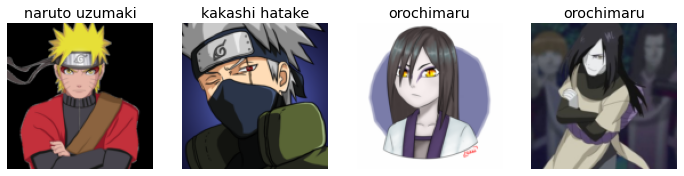

In [58]:
dls.valid.show_batch(max_n=4, nrows=1)

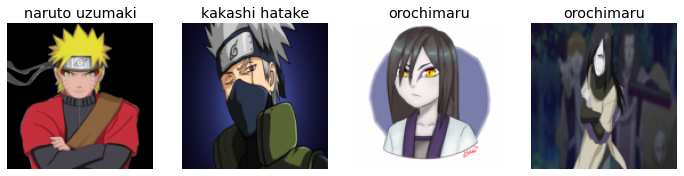

In [59]:
characters = characters.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = characters.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

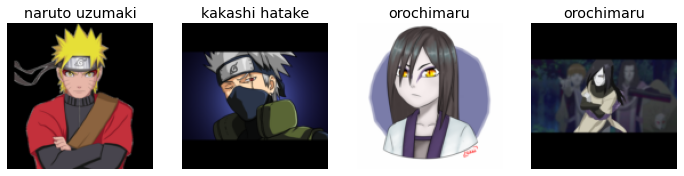

In [60]:
characters = characters.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = characters.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

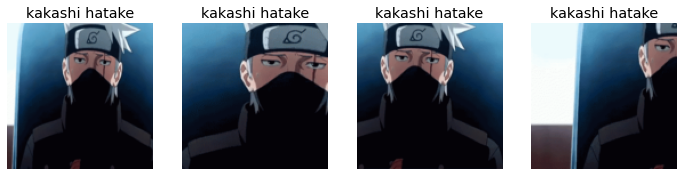

In [61]:
characters = characters.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = characters.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

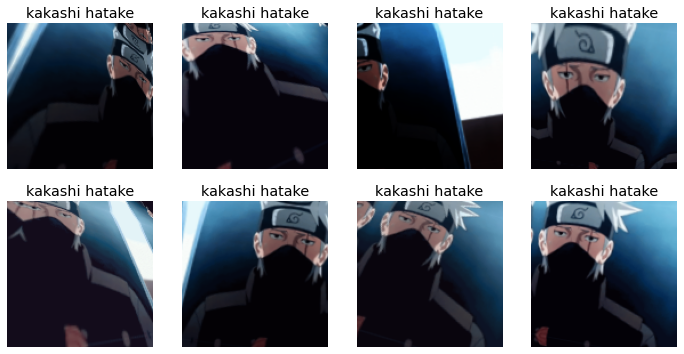

In [62]:
characters = characters.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = characters.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [101]:
characters = characters.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = characters.dataloaders(path)

In [102]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(25)

epoch,train_loss,valid_loss,error_rate,time
0,2.886778,1.321012,0.468293,00:08


/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


epoch,train_loss,valid_loss,error_rate,time
0,1.417640,0.993494,0.341463,00:09
1,1.246626,0.839439,0.292683,00:09
2,1.093737,0.691126,0.224390,00:10
3,0.954788,0.580786,0.165854,00:08
4,0.806585,0.497382,0.146341,00:08
5,0.671988,0.461651,0.136585,00:08
6,0.567007,0.439111,0.117073,00:09
7,0.470131,0.418808,0.117073,00:09
8,0.394883,0.389253,0.117073,00:09
9,0.331322,0.406887,0.121951,00:09


/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:960: U

/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:960: U

/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


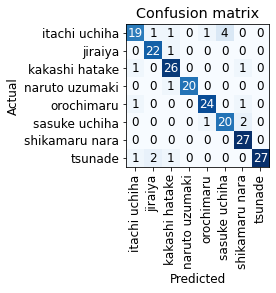

In [103]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

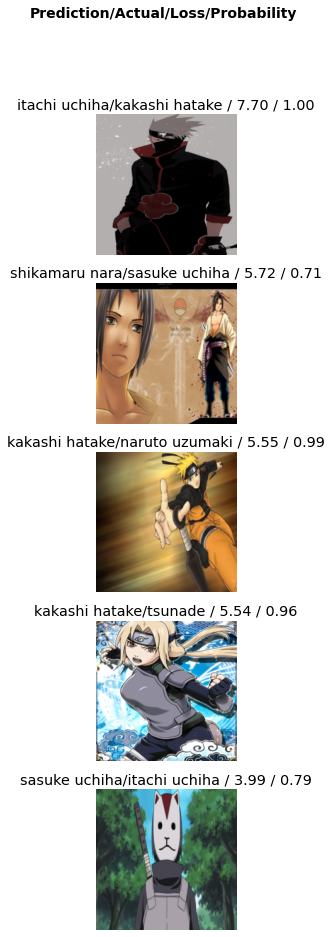

In [104]:
interp.plot_top_losses(5, nrows=5)

In [105]:
cleaner = ImageClassifierCleaner(learn)
cleaner

/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [110]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [ ]:
learn.export()

In [ ]:
path = Path()
path.ls(file_exts='.pkl')

export.pkl is the trained model
below is a test predictions

In [ ]:
learn_inf = load_learner(path/'export.pkl')

In [ ]:
btn_upload = widgets.FileUpload()
btn_upload

In [ ]:
img = PILImage.create(btn_upload.data[-1])

In [ ]:
pred,pred_idx,probs = learn_inf.predict(img)

In [ ]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

In [ ]:
btn_run = widgets.Button(description='Classify')

In [ ]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [ ]:
btn_upload = widgets.FileUpload()

In [ ]:
VBox([widgets.Label('Select a character!'), 
      btn_upload, btn_run, out_pl, lbl_pred])